# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from mxnet.gluon.data.dataset import ArrayDataset

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader2(batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2]):
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform[0])
    origin_data = gluon.data.DataLoader(origin_ds, batch_size[0], shuffle=False, last_batch='keep', num_workers=num_workers[0])
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform[1])
    train_data = gluon.data.DataLoader(train_ds, batch_size[1], shuffle=True, last_batch='keep', num_workers=num_workers[1])
    
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform[2])
    test_data = gluon.data.DataLoader(test_ds, batch_size[2], shuffle=False, last_batch='keep', num_workers=num_workers[2])
    return (origin_data, train_data, test_data), (origin_ds, train_ds, test_ds)

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

In [3]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [4]:
from cifar10_utils import show_images
import utils
import os, shutil
%matplotlib inline

EPS = 1e-30

def show_data(data, clip=True):
    images = inv_normalize(data, clip=clip)
    show_images(images)
    
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)
   
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
    
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    return t
    
def inv_normalize(data, mean=None, std=None, clip=True, asnumpy=True):
    if mean is None: mean=nd.array([0.4914, 0.4822, 0.4465])
    if std is None: std=nd.array([0.2023, 0.1994, 0.2010])
    if asnumpy: 
        data, mean, std = data.asnumpy(), mean.asnumpy(), std.asnumpy()
    images = data.transpose((0, 2, 3, 1))
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images


class BackGradDataGenerator:
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
#         if str(context)[:3] != "cpu":
#             print "warring: data was not in CPU, the returned backgrad_data is shallow copy of data."
        
        if bn_control is not None:
            bn_control.store()

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        for iters in range(1, max_iters+1):
            with autograd.record():
                data.attach_grad()
                output = net(data)
                loss = -loss_f(output, label)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()     # reduce will make memory release

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss

            BackGradDataGenerator.SGD(data, lr)
        if bn_control is not None:
            bn_control.load()
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
    
    @staticmethod
    def generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,
                            use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                            loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=None, begin_index=0):
        out_idx, iters = begin_index, 0
        diffs, losses, MSEs, SNRs, bloss = None, None, None, None, 0
        
        bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
        bn_backup.store()
        for data, label in origin_data:
            backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data(
                net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            bloss += _bloss

            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
                
            # must copy to cpu, or will make gpu memory leak(not release)
            backgrad_data = inv_normalize(backgrad_data, clip=False, asnumpy=False)
            out_data[out_idx:out_idx+data.shape[0], :, :, :] = backgrad_data.transpose((0, 2, 3, 1)).as_in_context(mx.cpu())
            out_idx += data.shape[0]
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False))
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy())
            iters += 1
        bn_backup.load()
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs    
        
BGG = BackGradDataGenerator

origin-train[:half]: 0.0
origin-train[half:]: 0.0
0.0
accuracy: 0.0


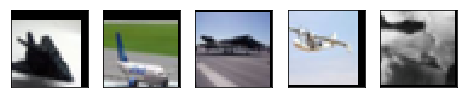

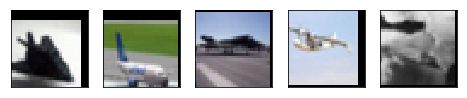

(0.99206758, 1.877763, 0.7500568, 0.16958953)
(-2.9394472, -2.6148734, -4.0964046, 0.21350281)
(0.00032973912, 0.0011477844, 0.00018313322, 0.0001294479)
(38.45153, 43.220634, 34.137909, 1.2348915)
accuracy: 0.0
origin-train[:half]: 0.0
origin-train[half:]: 21.216
143.69 143.69
65.251 78.2777


In [10]:
def test(net):
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_data_array, origin_label_array = origin_data_array[:128], origin_label_array[:128]
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform_train_DA1)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    data1 = None
    for d, l in train_data:
        if data1 is None:
            data1 = d.copy()
        else:
            print nd.mean(nd.abs(d - data1)).asscalar()
    
    net = ResNet(10)
    net.initialize(ctx=ctx)
    #net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    # net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.5,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(x) for x in xs])
    
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    print nd.mean(origin_ds._data[0]).asscalar(), nd.mean(train_ds._data[0][0]).asscalar()
    print np.std(origin_ds._data[0].asnumpy()), np.std(train_ds._data[0][1].asnumpy())
test()

random init
accuracy: 0.0


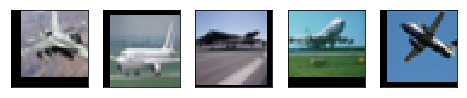

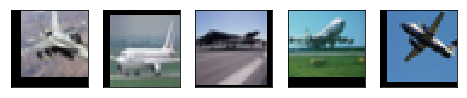

(0.29300398, 0.38227999, 0.22573017, 0.024929641)
(-2.7975812, -2.5789812, -3.2611914, 0.11418618)
(2.8148705e-05, 4.7570957e-05, 1.6586624e-05, 4.9303881e-06)
(48.881302, 52.821678, 45.09359, 1.7340878)
accuracy: 0.0

resnet18_me_200e
accuracy: 1.0


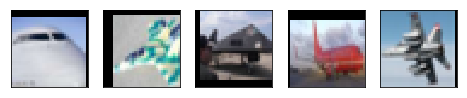

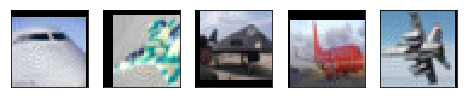

(3.0312138, 7.4958253, 1.5127808, 0.88557267)
(-19.562504, 0.0, -37.259007, 11.547222)
(0.0032462552, 0.018290168, 0.00074495625, 0.002108779)
(28.984108, 37.278542, 21.863974, 3.1700728)
accuracy: 0.6171875

online_iter10_lr01
accuracy: 0.99609375


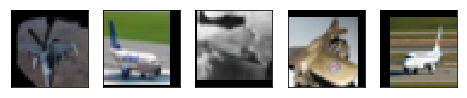

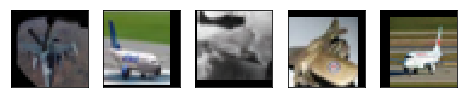

(1.7057624, 2.85057, 0.53837901, 0.49976811)
(-8.6891737, -0.00012075172, -22.365715, 6.3630047)
(0.0010284482, 0.0026451007, 9.4352865e-05, 0.00054488704)
(33.966564, 44.95858, 27.079662, 3.5466392)
accuracy: 0.96875



In [17]:
def test():
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_data_array, origin_label_array = origin_data_array[:128], origin_label_array[:128]
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform_train_DA1)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    net = ResNet(10)
    
    net.initialize(ctx=ctx)
    print "random init"
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(x) for x in xs])
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    print
    
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print "resnet18_me_200e"
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(x) for x in xs])
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    print
    
    net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    print "online_iter10_lr01"
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(x) for x in xs])
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    print
    
test()

In [5]:
class BackGradTrain(TrainPipeline):
    """
        1. add loss and diff/MSE/SNR to evaluate and control generate images
        2. BN layer: set use_gloabl_stats=True to use global mean/std and stop moving mean cal when genarate images, and set False after geneate.
        3. using DA after genereate images, means no DA when generate images
        4.
    """
    def __init__(self, net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers=None, 
                 output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), mixup_alpha=None,
                 back_grad_args=None):
        super(BackGradTrain, self).__init__(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx,
                                            w_key, trainers, output_file, verbose, loss_f, mixup_alpha, back_grad_args) 
        
    def initialize(self):
        super(BackGradTrain, self).initialize()
        if self.back_grad_args is not None:
            self.back_grad_args['num_epoch_per_round'] = self.back_grad_args.get('num_epoch_per_round', 1)
            self.back_grad_args['verbose'] = self.back_grad_args.get('verbose', False)
    
    def after_epoch(self, epoch, train_loss, train_acc):
        super(BackGradTrain, self).after_epoch(epoch, train_loss, train_acc)
    
    def after_iter(self, i, _loss, _acc):
        super(BackGradTrain, self).after_iter(i, _loss, _acc)
    
    def statistic(self, diffs):
        t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
        return t
      
    def run(self):
        self.initialize()
        if self.back_grad_args is not None:
            num_epoch_per_round = self.back_grad_args['num_epoch_per_round']
            max_iters, lr = self.back_grad_args['max_iters'], self.back_grad_args['lr']
            origin_data, b_verbose = self.back_grad_args['origin_data'], self.back_grad_args['verbose']
            use_batch_mean_std, train_ds = self.back_grad_args['use_batch_mean_std'], self.back_grad_args['train_ds']
        epoch_round = 0
        
        for epoch in range(self.start_epoch, self.start_epoch+self.num_epochs):
            # 1. train net
            train_loss, train_acc, i = 0., 0., 0
            for data, label in self.train_data:
                with autograd.record():
                    data, label = data.as_in_context(ctx), label.as_in_context(ctx)
                    output = self.net(data)
                    loss = self.loss_f(output, label)
                loss.backward()
                for trainer in self.trainers:
                    trainer.step(data.shape[0])

                _loss = nd.mean(loss).asscalar() 
                _acc = utils.accuracy(output, label)
                train_loss += _loss
                train_acc += _acc

                self.after_iter(i, _loss, _acc)
                i += 1
                
            # 2. generate new backgrad data
            if self.back_grad_args is not None and (epoch - self.start_epoch + 1) % num_epoch_per_round == 0:
                diff, gloss, MSE, SNR = BGG.generate_data_for_out(self.net, origin_data, max_iters, lr, use_batch_mean_std,
                                            True, None, loss_f, out_data=train_ds._data[0][1], begin_index=0)
                
                if b_verbose:
                    print "# epoch_round, generate data info (mean, max, min, std):", epoch_round
                    print "#     diff:", diff
                    print "#     loss:", gloss
                    print "#     MSE :", MSE
                    print "#     SNR :", SNR
                epoch_round += 1
                
            self.after_epoch(epoch, train_loss, train_acc)
            
        if self.output_file == sys.stdout:
            sys.stdout = self.stdout
            self.output_file.close()
            
    def run2(self, prob=0.5):
        self.initialize()
        if self.back_grad_args is not None:
            num_epoch_per_round = self.back_grad_args['num_epoch_per_round']
            max_iters, lr = self.back_grad_args['max_iters'], self.back_grad_args['lr']
            origin_data, b_verbose = self.back_grad_args['origin_data'], self.back_grad_args['verbose']
            use_batch_mean_std, train_ds = self.back_grad_args['use_batch_mean_std'], self.back_grad_args['train_ds']
        epoch_round = 0
        
        bn_backup = BNControl(self.net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
        
        for epoch in range(self.start_epoch, self.start_epoch+self.num_epochs):
            # 1. train net
            train_loss, train_acc, i, bloss = 0., 0., 0, 0
            for data, label in self.train_data:
                data, label = data.as_in_context(ctx), label.as_in_context(ctx)
                if i > 0 and random() < prob:
                    data,( _, _bloss) = BGG.generate_backgrad_data(self.net, data, label, max_iters, lr, False, False, loss_f, bn_backup)
                    bloss += _bloss
                    
                with autograd.record():
                    output = self.net(data)
                    loss = self.loss_f(output, label)
                loss.backward()
                for trainer in self.trainers:
                    trainer.step(data.shape[0])

                _loss = nd.mean(loss).asscalar() 
                _acc = utils.accuracy(output, label)
                train_loss += _loss
                train_acc += _acc

                self.after_iter(i, _loss, _acc)
                i += 1
                
            if b_verbose:
                print "bloss %.4f, " % (bloss / len(self.train_data)),
            epoch_round += 1
                
            self.after_epoch(epoch, train_loss, train_acc)
            
        if self.output_file == sys.stdout:
            sys.stdout = self.stdout
            self.output_file.close()
            


# 5. get net and do EXP

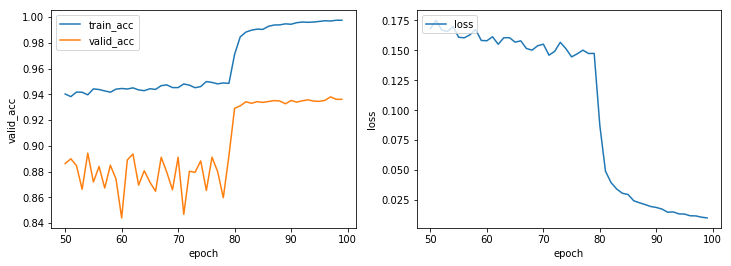

lr [0.1, 0.01, 0.001]


In [13]:
update('../../log/resnet18_me_200e.log', x_range=(50, 100))
# show_log('../../log/resnet18_me_200e.log')

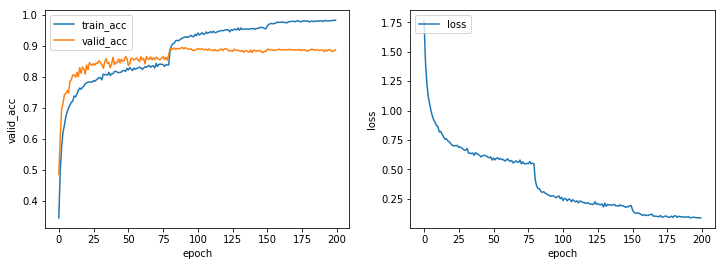

lr [0.1, 0.01, 0.001]


In [11]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log', x_range=(0, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log')

##  5.2 simple test ,use_batch_mean_std=True/False

In [8]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train8_resnet18_r1_i10_lr01_bT.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()

net.save_params("../../models/train8_resnet18_r1_i10_lr01_bT")

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train8_resnet18_r1_i10_lr01_bF.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 4, 4])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': False, 'train_ds': train_ds}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()
net.save_params("../../models/train8_resnet18_r1_i10_lr01_bF")

In [6]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 15
policy = {'lr': 0.01, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [10]}
w_key = []
trainers = None
log_file = "../../log/train8_resnet18_r1_i10_lr01_bT_finetune.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run2()

net.save_params("../../models/train8_resnet18_r1_i10_lr01_bT_finetune_prob")